In [ ]:
import shutil
import optparse
from os import listdir, mkdir
from os.path import abspath, join, exists
from codecs import open
from lxml import etree
from math import floor
import glob
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import os,sys

In [ ]:
import cv2
from PIL import Image

In [ ]:
def bbox_voc2yolo(bx, w, h):
    x1 = bx[0]
    y1 = bx[1]
    x2 = bx[2]
    y2 = bx[3]
    w_bbox = x2 - x1
    h_bbox = y2 - y1
    x_c = x1 + w_bbox/2
    y_c = y1 + h_bbox/2
    bbox = [x_c/w, y_c/h, w_bbox/w, h_bbox/h]
    return bbox

def bbox_yolo2voc(bx, w, h):
    x_c = float(bx[0])*w
    y_c = float(bx[1])*h
    wbbox = float(bx[2])*w
    hbbox = float(bx[3])*h
    x1 = int(x_c - wbbox/2)
    y1 = int(y_c - hbbox/2)
    x2 = int(x_c + wbbox/2)
    y2 = int(y_c + hbbox/2)
    bbox = [x1, y1, x2, y2]
    return bbox

def bbox_coco2voc(bbox):
    # bbox[0] = bbox[0] - bbox[2]/2
    # bbox[1] = bbox[1] - bbox[3]/2
    bbox[2] = bbox[0] + bbox[2]
    bbox[3] = bbox[1] + bbox[3]
    return bbox

In [ ]:
def draw_bbox(img_np, box_coco):
    
    id_ = box_coco[0]
    if not isinstance(id_, str):
        id_ = int(id_)
    x1 = int(box_coco[1])
    y1 = int(box_coco[2])
    x2 = int(box_coco[3])
    y2 = int(box_coco[4])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(img_np,(x1, y1),(x2, y2),(0,0,255),thickness=2)
    f = cv2.putText(img_np, text=str(id_), org=(x1 + 5, y1 + 5), fontFace=font, fontScale=0.7, 
        thickness=2, lineType=cv2.LINE_AA, color=(0, 255, 0))
    return img_np

In [ ]:
def read_bboxes(txtp):
    with open(txtp, 'r') as f:
        txt = f.readlines()
    return txt

def get_bboxes_text(txtp):
    import re
    tx_str = read_bboxes(txtp)
    bboxes = []
    for line in tx_str:
        line_list = re.split(r'[\s\n\t]',line)
        bx = []
        bx.append(int(line_list[0]))
        for item in line_list[1:]:
            if len(item.strip())>0:
                bx.append(float(item))
        bboxes.append(bx)
    return bboxes

In [ ]:
def copy_data(plist, mode='copy'):
    ps = plist[0]
    pt = plist[1]
    shutil.copyfile(ps, pt)
    
def write_txt(input_list):
    label_path, text = input_list[0], input_list[1]
    with open(label_path, 'a+') as f:
        f.write(text)

In [ ]:
names = {0: ['小西装', 'Suit_xizhuang'],  
 1: ['毛衣/绒衣/针织衫', 'Sweater/knit'],   
 2: ['女衫类', 'Blouses '],   
 3: ['皮衣外套', 'Leather coat'],   
 4: ['夹克外套', 'Jacket/coat '],    
 5: ['风衣', 'dust coat'],    
 6: ['背心', 'vest'],    
 7: ['吊带', 'harness'],    
 8: ['牛仔外套', 'Denim jacket'],    
 9: ['羽绒服', 'Down jacket'],    
 10: ['大衣', 'coat'],   
 11: ['皮草', 'fur'],    
 12: ['卫衣', 'fleece'],     
 13: ['棉衣/羊羔绒', 'Padded coat'],    
 14: ['斗篷', 'cloak'],    
 15: ['半身裙', 'skirt'],
 16: ['西装裤', 'Suit pants'],    
 17: ['牛仔裤', 'Jeans'],     
 18: ['休闲裤', 'Slacks'],      
 19: ['打底裤', 'Leggings'],    
 20: ['运动裤', 'Sweatpants'],
21: ['连衣裙', 'Dress'],     
 22: ['连衣裤', 'Jumpsuit'],    
 23: ['正装女鞋', 'Suits shoes'],   
 24: ['帆布鞋', 'Canvas shoes'],     
 25: ['松糕鞋', 'Platform shoes'],    
 26: ['洞洞鞋', 'Hole shoes'],     
 27: ['懒人鞋', 'Lazy shoes'],     
 28: ['板鞋', 'board shoes'],    
 29: ['拖鞋', 'slippers'],     
 30: ['凉鞋', 'sandals'],    
 31: ['运动鞋', 'Sports shoes'],    
 32: ['雪地靴', 'Ugg boots'],   
 33: ['豆豆鞋', 'Doug shoes'],    
 34: ['网鞋', 'Net shoes'],      
35: ['包', 'bag'],   
36:['衬衫', 'shirt'],  
37:['T恤', 'T-shirt'],
38:['POLO衫','POLO shirt'],
39:['马甲', 'Vest'] ,
40:['棒球服', 'Baseball uniform'], 
41:['抹胸', 'Bandeau'],
42:['皮裤','Leather pants'],
43:['休闲鞋','Leisure shoes'],
44:['帽子','Hat'],}

### 转yolo

In [ ]:
def get_yolo_bbox(row):
    w,h = row['width'], row['height']
    bbox = row.loc[[ 'xmin','ymin', 'xmax', 'ymax']].values
    bbox = bbox_voc2yolo(bbox, w, h)
    bboxes_list.append(bbox)

In [ ]:
%%time
df = hw_df
bboxes_list = []
_ = df.apply(lambda row: get_yolo_bbox(row), axis=1)

In [ ]:
col_name = 'xmin'
ind = 0
df[col_name] = [x[ind] for x in bboxes_list]

### Data all infomation

In [ ]:
!ls /nas/chenyi/datasets_nas/openfashion

In [ ]:
!ls /nas/chenyi/datasets_nas/openfashion/openfashion3

In [ ]:
dp23 = pd.read_csv('/nas/chenyi/datasets_nas/openfashion/deepedia2/deepedia_catg23_yolo.csv')

In [ ]:
dp23.head()

In [ ]:
dp23.describe()

In [ ]:
dp23.value_counts('source')

In [ ]:
dp23[dp23['source']==dp23.value_counts('source').axes[0][0]].describe()

In [ ]:
opf = pd.read_csv('/nas/chenyi/datasets_nas/openfashion/openfashion45_coco.csv')

In [ ]:
# /nas/chenyi/datasets_nas/openfashion/openfashion_info.csv

In [ ]:
opf.head()

In [ ]:
len(opf)

In [ ]:
opf.value_counts('source')

In [ ]:
opf.value_counts('source').axes[0][0]

In [ ]:
opf.describe()

In [ ]:
opf[opf['source']==opf.value_counts('source').axes[0][0]].describe()

In [ ]:
opf[opf['source']==opf.value_counts('source').axes[0][1]].describe()

In [ ]:
opf[opf['source']==opf.value_counts('source').axes[0][2]].describe()

In [ ]:
fp_df = opf[opf['source']==opf.value_counts('source').axes[0][2]]

In [ ]:
opf.columns

In [ ]:
dp23.loc[dp23[dp23['source']==dp23.value_counts('source').axes[0][1]].index, ['x_1', 'y_1', 'x_2', 'y_2', 'path']].head(2).values

In [ ]:
opf.loc[opf[opf['source']==opf.value_counts('source').axes[0][2]].index, ['xmin', 'ymin', 'xmax', 'ymax', 'path']].head(2).values

In [ ]:
# opf.loc[opf[opf['source']==opf.value_counts('source').axes[0][2]].index, ['xmin', 'ymin', 'xmax', 'ymax', 'path']] = dp23.loc[dp23[dp23['source']==dp23.value_counts('source').axes[0][1]].index, ['x_1', 'y_1', 'x_2', 'y_2', 'path']].values

In [ ]:
opf = pd.read_csv('/nas/chenyi/datasets_nas/openfashion/allfashion/openfashion45_data_clear.csv')

In [ ]:
# opf.loc[opf[opf['source']==opf.value_counts('source').axes[0][2]].index, ['xmin']] = \
#             opf.loc[opf[opf['source']==opf.value_counts('source').axes[0][2]].index, ['xmin']].values* opf.loc[opf[opf['source']==opf.value_counts('source').axes[0][2]].index, ['width']].values

In [ ]:
opf.loc[:, ['ymin']] = \
            opf.loc[:, ['ymin']].values/ opf.loc[:, ['height']].values

In [ ]:
opf[opf['source']==opf.value_counts('source').axes[0][2]].head(2)

In [ ]:
opf.describe()

In [ ]:
# opf.to_csv('/nas/chenyi/datasets_nas/openfashion/allfashion/openfashion45_data_clear.csv', index=False)

### 数据分析

In [1847]:
!ls /nas/chenyi/datasets_nas/openfashion/allfashion/

del_df_temp0511.csv  openfashion31_clr_temp.csv  openfashion45_bbox_yolo.csv
del_df_temp.csv      openfashion43_clear.csv	 openfashion45_data_clear.csv


In [1771]:
ofashion43 = pd.read_csv('/nas/chenyi/datasets_nas/openfashion/allfashion/openfashion43_clear.csv')

/tmp/ipykernel_238968/3609604243.py:1: DtypeWarning: Columns (3,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ofashion43 = pd.read_csv('/nas/chenyi/datasets_nas/openfashion/allfashion/openfashion43_clear.csv')


In [ ]:
# ofashion43_clr.to_csv('/nas/chenyi/datasets_nas/openfashion/openfashion43_clr.csv', index=False)

In [1848]:
ofashion43.tail(2)

,source,path,label2_eng,label1_chi,label43,label2_chi,xmin,ymin,xmax,ymax,height,width,fname,mode,len
330021,haowei34k,/home/chenyi/workspace/dataset/data/haowei34k/...,Suits shoes,NaN,23,正装女鞋,0.515455,0.854048,37.0,98.0,877,550,20150327124301904,train,4
330022,haowei34k,/home/chenyi/workspace/dataset/data/haowei34k/...,Suits shoes,NaN,23,正装女鞋,0.680000,0.932155,40.0,111.0,877,550,20150327124301904,train,4


In [1849]:
ofashion43.describe()

,label43,xmin,ymin,xmax,ymax,height,width,len
count,330023.000000,330023.000000,330023.000000,330023.000000,330023.000000,330023.000000,330023.000000,330023.000000
mean,17.338358,0.497437,0.590240,224.026980,325.557876,872.134563,641.945089,2.686576
std,9.138335,0.088464,0.195693,147.718043,211.656350,364.907984,251.726624,1.720974
min,0.000000,0.029333,0.025000,3.000000,4.000000,71.000000,68.000000,1.000000
25%,12.000000,0.458578,0.441995,108.000000,157.000000,631.000000,468.000000,1.000000
50%,21.000000,0.498932,0.561250,199.000000,292.000000,832.000000,640.000000,2.000000
75%,23.000000,0.537500,0.715105,307.000000,448.000000,1024.000000,750.000000,4.000000
max,42.000000,0.995528,0.990469,2038.000000,3310.000000,6286.000000,4195.000000,21.000000


In [1850]:
len(ofashion43)

330023

In [ ]:
# ofashion43_coco = ofashion43
# ofashion43_coco['xmin'] = ofashion43_coco['xmin']*ofashion43_coco['width']
# ofashion43_coco['ymin'] = ofashion43_coco['ymin']*ofashion43_coco['height']
# ofashion43_coco['xmax'] = ofashion43_coco['xmax']*ofashion43_coco['width']
# ofashion43_coco['ymax'] = ofashion43_coco['ymax']*ofashion43_coco['height']
# ofashion43 = ofashion43_coco

In [1851]:
ofashion43['label43'].max()

42

##### 去掉休闲鞋和帽子

In [ ]:
ofashion43 = ofashion43[ofashion43['label43']<=42]

In [ ]:
len(ofashion43)

##### 小物体鞋子和包

In [ ]:
ofashion43_shbg = ofashion43[(ofashion43['label43']>=23)& (ofashion43['label43']<=35)]

In [ ]:
ofashion43_big = ofashion43[~(ofashion43['label43']>=23)& (ofashion43['label43']<=35)]

In [ ]:
# ofashion43_big = ofashion43[~ofashion43['path'].isin(ofashion43_img_shbg['path'])]

In [ ]:
ofashion43_shbg.head()

In [ ]:
ofashion43_shbg.describe()

In [ ]:
hw_shbg = ofashion43_shbg[ofashion43_shbg['source']=='haowei34k']

In [ ]:
hw_shbg.describe()

##### 坐标核对

In [ ]:
bbox_dirty = ofashion43_big[(ofashion43_big['ymax']<0) | (ofashion43_big['xmax']<0)]

In [ ]:
len(bbox_dirty)

In [ ]:
ofashion43_clr = ofashion43_big[(ofashion43_big['ymax']>0) & (ofashion43_big['xmax']>0)]

##### BBOX大小核对

In [ ]:
ofashion43_small = ofashion43_big[(ofashion43_big['ymax']<100) | 
                                  (ofashion43_big['xmax']<100) |
                                 (ofashion43_big['width']<200) |
                                 (ofashion43_big['height']<300)]

In [ ]:
bbox_dirty = pd.concat([bbox_dirty, ofashion43_small], axis=0)

In [ ]:
bbox_dirty.describe()

In [ ]:
len(bbox_dirty.drop_duplicates('path'))

In [ ]:
img_drop_df = bbox_dirty.drop_duplicates('path')

In [ ]:
ofashion31_clr_temp = ofashion43_big[~ofashion43_big['path'].isin(img_drop_df['path'])]

In [ ]:
len(ofashion31_clr_temp)

In [ ]:
len(ofashion31_clr_temp.drop_duplicates('path'))

In [ ]:
ofashion31_clr_temp.describe()

In [ ]:
ofashion31_clr_temp.drop_duplicates('path').value_counts('source')

In [1602]:
ofashion31_clr = pd.read_csv('/nas/chenyi/datasets_nas/openfashion/allfashion/openfashion31_clr_temp.csv')

/tmp/ipykernel_238968/3092985983.py:1: DtypeWarning: Columns (3,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ofashion31_clr = pd.read_csv('/nas/chenyi/datasets_nas/openfashion/allfashion/openfashion31_clr_temp.csv')


In [1603]:
ofashion31_clr.head()

,source,path,label2_eng,label1_chi,label43,label2_chi,xmin,ymin,xmax,ymax,height,width,fname,mode,len
0,DeepFashion2,/home/chenyi/workspace/dataset/data/DeepFashio...,long sleeve dress,连体装,21,连衣裙,0.500000,0.530649,466.0,779.0,832,468,3,NaN,1
1,DeepFashion2,/home/chenyi/workspace/dataset/data/DeepFashio...,long sleeve dress,连体装,21,连衣裙,0.498932,0.589744,467.0,510.0,624,468,4,NaN,1
2,DeepFashion2,/home/chenyi/workspace/dataset/data/DeepFashio...,long sleeve dress,连体装,21,连衣裙,0.500000,0.548077,466.0,716.0,832,468,5,NaN,1
3,DeepFashion2,/home/chenyi/workspace/dataset/data/DeepFashio...,long sleeve dress,连体装,21,连衣裙,0.497863,0.694111,466.0,507.0,832,468,6,NaN,1
4,DeepFashion2,/home/chenyi/workspace/dataset/data/DeepFashio...,long sleeve dress,连体装,21,连衣裙,0.483974,0.571225,407.0,590.0,702,468,7,NaN,1


##### CHECK Area

In [ ]:
# %%time
# # 计算bbox的面积
# df = ofashion43.copy(deep=True)
# area_list = []
# for ind,row in tqdm(df.iterrows()):
#     whWH = row.loc[['xmax', 'ymax']].values
#     area  = 1
#     for item in whWH:
#         area *= item
#     area_list.append(area)
#     # break

In [ ]:
ofashion43['area'] = area_list

##### bbox的个数

In [ ]:
# %%time
# 计算bbox的个数
# ofashion43['len'] = 0
# for ind,p_ in tqdm(enumerate(pcounter.index)):
#     num = pcounter.values[ind]
#     ofashion43.loc[ofashion43[ofashion43['path'] == p_].index, 'len'] = num

In [1626]:
len(ofashion31_clr.value_counts('label43'))

23

In [1647]:
ofashion31_clr.value_counts('label43').sort_index()

label43
0      2252
1      8719
2      8688
3      1558
4     27671
5       331
6     19446
7      2598
8       911
9       169
10     1046
11      273
12     1304
13      294
14       26
15    46741
16      952
17     5692
18     7268
19      808
20      143
21    82355
22     1303
dtype: int64

In [1637]:
dp_df = ofashion31_clr[~(ofashion31_clr['source'] == 'haowei34k')]
dp_len1 = dp_df[dp_df['len']==1]

In [1654]:
num2eng[1]

'Sweater/knit'

In [1648]:
dp_len1.value_counts('label43').sort_index()

label43
1      1316
2      2111
4     17048
6     11605
7      1627
15    30061
21    68944
22      619
dtype: int64

In [1640]:
len(dp_len1)

133331

In [1638]:
ofashion31_clr_temp = ofashion31_clr[~ofashion31_clr['path'].isin(dp_len1['path'])]

In [1641]:
len(ofashion31_clr_temp)

87217

In [1642]:
ofashion31_clr_temp.to_csv('/nas/chenyi/datasets_nas/openfashion/allfashion/openfashion31_clr_temp.csv', index=False)

### Display

In [ ]:
hw_df = ofashion43[ofashion43['source']=='haowei34k']

In [ ]:
hw_df.describe()

In [ ]:
df = df[df['source']=='Fashionpedia']

In [ ]:
def bbox_coco2voc(bbox):
    # bbox[0] = bbox[0] - bbox[2]/2
    # bbox[1] = bbox[1] - bbox[3]/2
    bbox[2] = bbox[0] + bbox[2]
    bbox[3] = bbox[1] + bbox[3]
    return bbox

In [ ]:
p = df.iloc[300,1]

In [ ]:
df.head(3)

In [ ]:
x

In [ ]:
bboxes = []
x = df[df['path']==p]
for ind, row in x.iterrows():
    bbox = row.loc[['label_2', 'x_1','y_1', 'x_2', 'y_2']].values.tolist()
    # bbox[1:] = bbox_coco2voc(bbox[1:])
    # bbox[0] = row['label2_eng']
    bboxes.append(bbox)

In [ ]:
# bboxes = []
# x = df[df['path']==p]
# for ind, row in x.iterrows():
#     bbox = row.loc[['label43', 'xmin','ymin', 'xmax', 'ymax']].values.tolist()
#     bbox[1:] = bbox_coco2voc(bbox[1:])
#     bbox[0] = row['label2_eng']
#     bboxes.append(bbox)

In [ ]:
img_np = cv2.imread(str(p))
img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
h = img_np.shape[0]
w = img_np.shape[1]
for bx in bboxes:
    bx[1:] = bbox_coco2voc(bx[1:])
    draw_bbox(img_np, bx)

In [ ]:
bboxes

In [ ]:
Image.fromarray(img_np)

#### Pandas画图

In [ ]:
ofashion43_small.head()

In [ ]:
df = ofashion43_small
i = 1100

In [ ]:
ind = df.index[i]
p = df.loc[ind]['path']
bboxes = [df.loc[ind][['label43', 'xmin','ymin', 'xmax', 'ymax']].values.tolist()]
id_ = df.loc[ind, 'label2_eng']
df.loc[ind, 'source']

In [ ]:
img_np = cv2.imread(str(p))
img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
h = img_np.shape[0]
w = img_np.shape[1]
for bx in bboxes:
    bx[0] = id_
    bx[1:] = bbox_coco2voc(bx[1:])
    draw_bbox(img_np, bx)

In [ ]:
Image.fromarray(img_np)

### Display HTML

In [1774]:
ofashion43.head(2)

,source,path,label2_eng,label1_chi,label43,label2_chi,xmin,ymin,xmax,ymax,height,width,fname,mode,len
0,DeepFashion2,/home/chenyi/workspace/dataset/data/DeepFashio...,long sleeve dress,连体装,21,连衣裙,0.500000,0.530649,466.0,779.0,832,468,3,NaN,1
1,DeepFashion2,/home/chenyi/workspace/dataset/data/DeepFashio...,long sleeve dress,连体装,21,连衣裙,0.498932,0.589744,467.0,510.0,624,468,4,NaN,1


In [1830]:
thred = 0.05
dis_df = ofashion43[((ofashion43['xmin']<thred) | (ofashion43['ymin']<thred) | 
                     (ofashion43['xmin']>1-thred) | (ofashion43['ymin']>1-thred)) & 
                    (ofashion43['len']==2)]

In [1831]:
dis_img_df = dis_df.drop_duplicates('path').sort_values('len', ascending=False)

In [1832]:
len(dis_df), len(dis_img_df)

(96, 96)

In [1833]:
# # dis_img_df['bboxes'] = []
# for ind,row in dis_img_df.iterrows():
#     p = row['path']
#     df_temp = dis_df[dis_df['path'] == p]
#     df_temp.loc[:,'xmax'] = df_temp.loc[:,'xmax'].values/df_temp.loc[:,'width'].values
#     df_temp.loc[:,'ymax'] = df_temp.loc[:,'ymax'].values/df_temp.loc[:,'height'].values
#     bboxes = df_temp.loc[:,['label2_eng', 'xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
#     break

In [1843]:
ind = 33
p = dis_img_df['path'].values[ind]
df_temp = ofashion43[ofashion43['path'] == p]
df_temp.loc[:,'xmax'] = df_temp.loc[:,'xmax'].values/df_temp.loc[:,'width'].values
df_temp.loc[:,'ymax'] = df_temp.loc[:,'ymax'].values/df_temp.loc[:,'height'].values
bboxes = df_temp.loc[:,['label2_eng', 'xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
df_temp.loc[:,['source']].values[0]

/tmp/ipykernel_238968/3148322742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.loc[:,'xmax'] = df_temp.loc[:,'xmax'].values/df_temp.loc[:,'width'].values
/tmp/ipykernel_238968/3148322742.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.loc[:,'ymax'] = df_temp.loc[:,'ymax'].values/df_temp.loc[:,'height'].values


array(['haowei34k'], dtype=object)

In [1844]:
ofashion43[ofashion43['path'] == p]

,source,path,label2_eng,label1_chi,label43,label2_chi,xmin,ymin,xmax,ymax,height,width,fname,mode,len
299351,haowei34k,/home/chenyi/workspace/dataset/data/haowei34k/...,Dress,NaN,21,连衣裙,0.507031,0.480208,229.0,528.0,960,640,20170616102433237,val,2
299352,haowei34k,/home/chenyi/workspace/dataset/data/haowei34k/...,Suits shoes,NaN,23,正装女鞋,0.526563,0.956250,92.0,68.0,960,640,20170616102433237,val,2


In [1845]:
img_np = cv2.imread(str(p))
img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
h = img_np.shape[0]
w = img_np.shape[1]
for bx in bboxes:
    bx[1:] = bbox_yolo2voc(bx[1:], w, h)
    draw_bbox(img_np, bx)

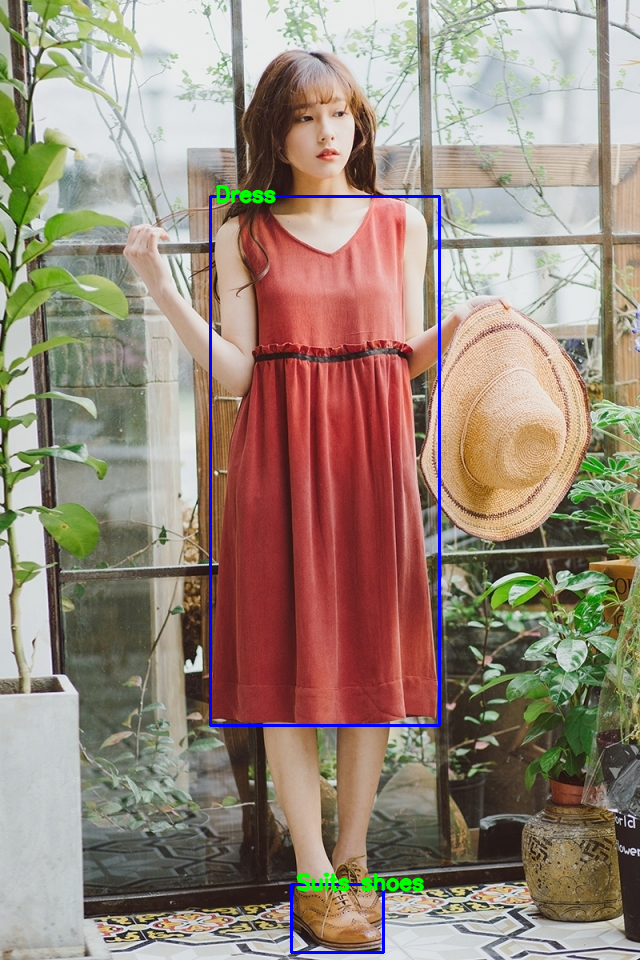

In [1846]:
Image.fromarray(img_np)

In [1439]:
eng2chi['Doug shoes'],eng2chi['Suits shoes'], eng2chi['Slacks']

('豆豆鞋', '正装女鞋', '休闲裤')

In [1440]:
# eng2chi = {}
# for k,v in names.items():
#     eng2chi[v[1]] = v[0]
#     # print(v)
#     # break

In [1573]:
# num2eng = {}
# for k,v in names.items():
#     num2eng[k] = v[1]
#     # break

#### Recording Delete Dirty image by Dispalye

In [1441]:
# del_df = pd.DataFrame()
# del_df['path'] = ''
# p_del_list = []

In [1442]:
len(p_del_list)

27

In [1443]:
p_del = p
p_del_list.append(p)
p_del_list = list(set(p_del_list))
len(p_del_list)

28

In [1444]:
del_df = pd.DataFrame()
del_df['path'] = ''
del_df['path'] = p_del_list

In [1445]:
del_df.tail().values, len(del_df)

(array([['/home/chenyi/workspace/dataset/data/haowei34k/images/train/20150102155511682.jpg'],
        ['/home/chenyi/workspace/dataset/data/haowei34k/images/train/20141226150446832.jpg'],
        ['/home/chenyi/workspace/dataset/data/haowei34k/images/train/20141229175513902.jpg'],
        ['/home/chenyi/workspace/dataset/data/haowei34k/images/val/20150409160444701.jpg'],
        ['/home/chenyi/workspace/dataset/data/haowei34k/images/train/20180616104635576.jpg']],
       dtype=object),
 28)

In [1322]:
if 0:
    del_df.to_csv('/nas/chenyi/datasets_nas/openfashion/allfashion/del_df_temp0511.csv', index=False)